Step 1: Imports

In [1]:
! git clone https://github.com/niharikavadapalli/ERA-V1.git

Cloning into 'ERA-V1'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 357 (delta 69), reused 81 (delta 27), pack-reused 220
Receiving objects: 100% (357/357), 2.13 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [2]:
%cd "/content/ERA-V1/ERA-V1-Session-11"
!pwd

/content/ERA-V1/ERA-V1-Session-11
/content/ERA-V1/ERA-V1-Session-11


In [3]:
from __future__ import print_function
!pip install torchsummary
!pip install torch-lr-finder
!pip install grad-cam
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

from main import main
from utils.visualize import plot_misclassified_images, plot_network_performance, print_samples, print_data_stats, print_train_log, plot_grad_cam_images
from utils.dataset import MyDataset
from utils.transform import get_loaders
from utils.utilities import plot_lr_finder, get_OneCycleLR
from models.resnet import ResNet18, ResNet


from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=e9f96e75f7c375a33ed8d2c616c020b382e266c2ab8d61cb3c0d9c096fe0bc01
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Step 2: Visualize and Prepare Data Transforms

100%|██████████| 170498071/170498071 [00:02<00:00, 64826362.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


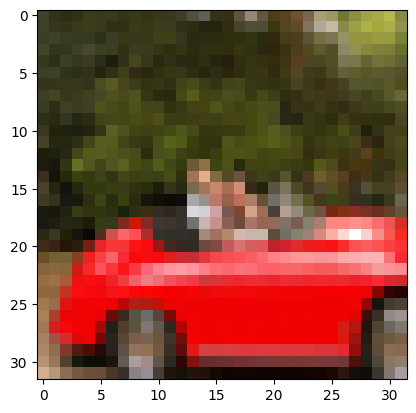

In [4]:
cifar10 =  datasets.CIFAR10('./data', train=True, download=True)
cifar10_val = datasets.CIFAR10('./data', train=False, download=True)
img, label = cifar10[99]
plt.imshow(img)
plt.show()

Step 4: Creating data loaders

In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("Is cuda available? ", cuda)

#set the seed of the random number generator to a fixed value
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

train_loader, test_loader = get_loaders(batch_size=512, use_cuda=cuda)


Is cuda available?  True


100%|██████████| 170498071/170498071 [00:02<00:00, 70915188.07it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


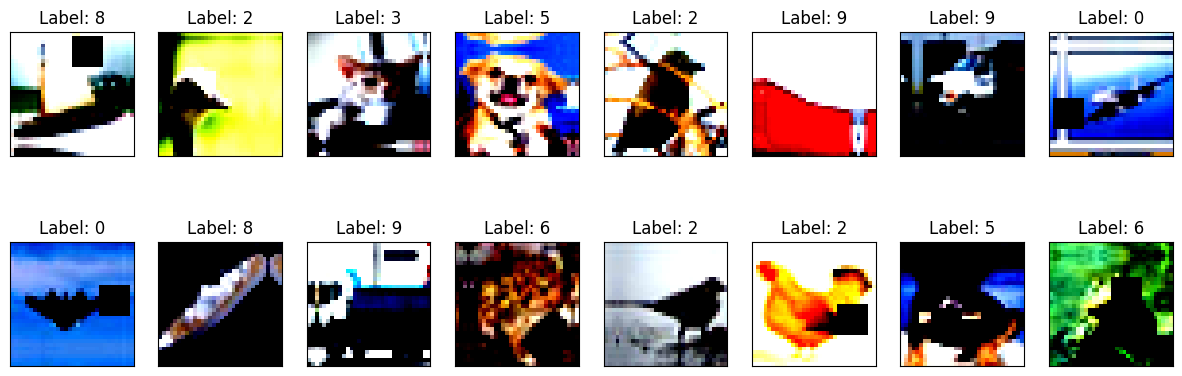

In [ ]:
print_samples(train_loader)

Step 5: Data Stats

In [ ]:
print_data_stats(train_loader)

{'horse': 5000, 'automobile': 5000, 'deer': 5000, 'ship': 5000, 'airplane': 5000, 'bird': 5000, 'dog': 5000, 'frog': 5000, 'cat': 5000, 'truck': 5000}


Step 6: Model Creation and Display Parameters

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.63E-02


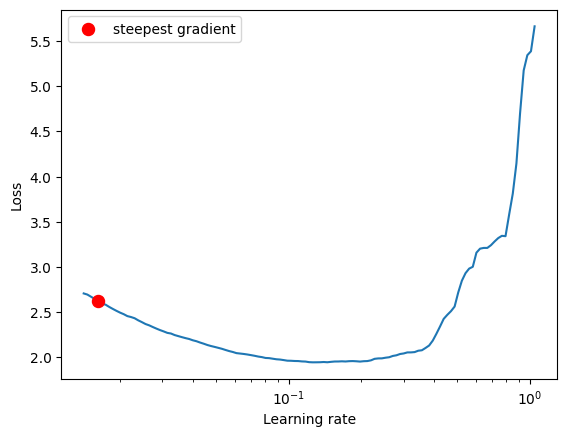

In [6]:
optimizer, criterion = plot_lr_finder(model, train_loader)

In [7]:
EPOCHS = 20
batch_size = 512
found_lr = 1.63E-02
scheduler = get_OneCycleLR(optimizer, EPOCHS, found_lr, train_loader)

Step 7: Training the model

In [8]:
trainer = main(model,EPOCHS, batch_size, scheduler, optimizer, criterion, device, train_loader, test_loader, found_lr)
trainer.run_model()


EPOCH: 0


Loss=1.2246454954147339 Batch_id=97 Accuracy=44.8920: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]



Test set: Average loss: 0.0041, Accuracy: 4343/10000 (43.4300%)


 current learing rate is 0.0033969999999999994
EPOCH: 1


Loss=0.996488094329834 Batch_id=97 Accuracy=60.8240: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0030, Accuracy: 5427/10000 (54.2700%)


 current learing rate is 0.006630999999999999
EPOCH: 2


Loss=0.8188982605934143 Batch_id=97 Accuracy=67.9720: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]



Test set: Average loss: 0.0027, Accuracy: 5429/10000 (54.2900%)


 current learing rate is 0.009864999999999999
EPOCH: 3


Loss=0.6478755474090576 Batch_id=97 Accuracy=72.3940: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0017, Accuracy: 7079/10000 (70.7900%)


 current learing rate is 0.013098999999999998
EPOCH: 4


Loss=0.7689679265022278 Batch_id=97 Accuracy=74.9320: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0023, Accuracy: 6134/10000 (61.3400%)


 current learing rate is 0.016288912673469387
EPOCH: 5


Loss=0.5833852291107178 Batch_id=97 Accuracy=76.7900: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0017, Accuracy: 7011/10000 (70.1100%)


 current learing rate is 0.015202354673469386
EPOCH: 6


Loss=0.5919156074523926 Batch_id=97 Accuracy=78.9800: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0014, Accuracy: 7532/10000 (75.3200%)


 current learing rate is 0.014115796673469386
EPOCH: 7


Loss=0.6365328431129456 Batch_id=97 Accuracy=80.1600: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0030, Accuracy: 5795/10000 (57.9500%)


 current learing rate is 0.013029238673469386
EPOCH: 8


Loss=0.554430365562439 Batch_id=97 Accuracy=81.4300: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0023, Accuracy: 6529/10000 (65.2900%)


 current learing rate is 0.011942680673469387
EPOCH: 9


Loss=0.45256900787353516 Batch_id=97 Accuracy=82.5700: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]



Test set: Average loss: 0.0015, Accuracy: 7603/10000 (76.0300%)


 current learing rate is 0.010856122673469387
EPOCH: 10


Loss=0.5060546398162842 Batch_id=97 Accuracy=83.3640: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0013, Accuracy: 7799/10000 (77.9900%)


 current learing rate is 0.009769564673469386
EPOCH: 11


Loss=0.4656554162502289 Batch_id=97 Accuracy=84.3060: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]



Test set: Average loss: 0.0013, Accuracy: 7886/10000 (78.8600%)


 current learing rate is 0.008683006673469386
EPOCH: 12


Loss=0.40717652440071106 Batch_id=97 Accuracy=85.5280: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0012, Accuracy: 8035/10000 (80.3500%)


 current learing rate is 0.007596448673469387
EPOCH: 13


Loss=0.36116740107536316 Batch_id=97 Accuracy=86.2020: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]



Test set: Average loss: 0.0009, Accuracy: 8516/10000 (85.1600%)


 current learing rate is 0.006509890673469387
EPOCH: 14


Loss=0.353346586227417 Batch_id=97 Accuracy=87.5420: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0010, Accuracy: 8308/10000 (83.0800%)


 current learing rate is 0.005423332673469386
EPOCH: 15


Loss=0.31453990936279297 Batch_id=97 Accuracy=88.5640: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]



Test set: Average loss: 0.0008, Accuracy: 8759/10000 (87.5900%)


 current learing rate is 0.004336774673469386
EPOCH: 16


Loss=0.331634521484375 Batch_id=97 Accuracy=90.0640: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0007, Accuracy: 8829/10000 (88.2900%)


 current learing rate is 0.0032502166734693864
EPOCH: 17


Loss=0.3245013356208801 Batch_id=97 Accuracy=91.3720: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.7700%)


 current learing rate is 0.0021636586734693868
EPOCH: 18


Loss=0.18485978245735168 Batch_id=97 Accuracy=93.3400: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0005, Accuracy: 9138/10000 (91.3800%)


 current learing rate is 0.0010771006734693871
EPOCH: 19


Loss=0.14607255160808563 Batch_id=97 Accuracy=95.1500: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]



Test set: Average loss: 0.0005, Accuracy: 9244/10000 (92.4400%)


 current learing rate is -9.457326530612487e-06


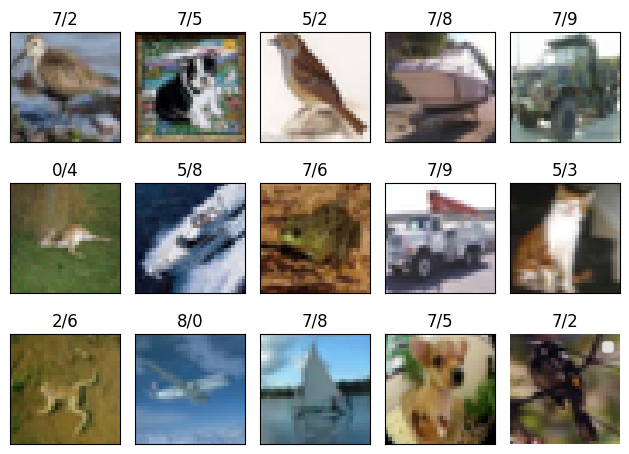

In [10]:
plot_misclassified_images(trainer.incorrect_examples, trainer.incorrect_pred, trainer.incorrect_labels)


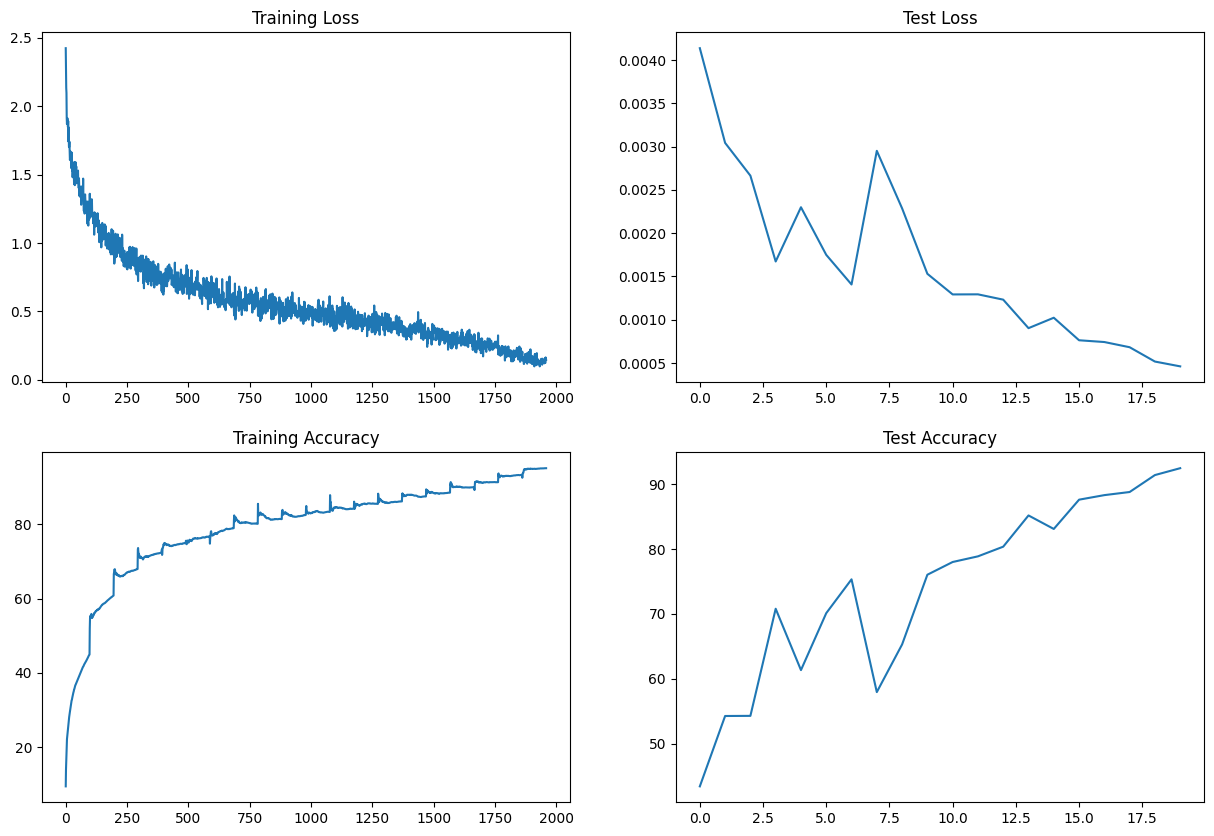

In [11]:
new_tensor = torch.tensor(trainer.train_losses, device = 'cpu')
plot_network_performance(new_tensor, trainer.test_losses, trainer.train_acc, trainer.test_acc)

In [12]:
print_train_log(EPOCHS, trainer.train_acc, trainer.test_acc, trainer.train_losses, trainer.test_losses, trainer.learning_rates)


Epoch	     Train Loss	     Test Loss     Train Accuracy    Test Accuracy    Learning Rate
1		2.42		0.00		9.3750		43.4300		0.00339700

2		2.29		0.00		13.8672		54.2700		0.00663100

3		2.13		0.00		15.8854		54.2900		0.00986500

4		2.10		0.00		18.0176		70.7900		0.01309900

5		1.91		0.00		20.0391		61.3400		0.01628891

6		1.87		0.00		22.1029		70.1100		0.01520235

7		1.90		0.00		22.7958		75.3200		0.01411580

8		1.91		0.00		23.4131		57.9500		0.01302924

9		1.88		0.00		24.2839		65.2900		0.01194268

10		1.85		0.00		25.0195		76.0300		0.01085612

11		1.89		0.00		25.4794		77.9900		0.00976956

12		1.74		0.00		26.0742		78.8600		0.00868301

13		1.84		0.00		26.6677		80.3500		0.00759645

14		1.71		0.00		27.5251		85.1600		0.00650989

15		1.70		0.00		28.0729		83.0800		0.00542333

16		1.74		0.00		28.4912		87.5900		0.00433677

17		1.68		0.00		28.8603		88.2900		0.00325022

18		1.61		0.00		29.4813		88.7700		0.00216366

19		1.62		0.00		29.9445		91.3800		0.00107710

20		1.67		0.00		30.3906		92.4400		-0.00000946

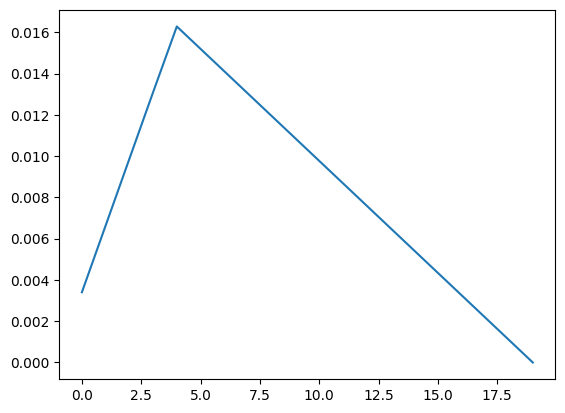

In [13]:
plt.plot(trainer.learning_rates)

/content/ERA-V1/ERA-V1-Session-11/utils/visualize.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(inv_tensor.unsqueeze(0))


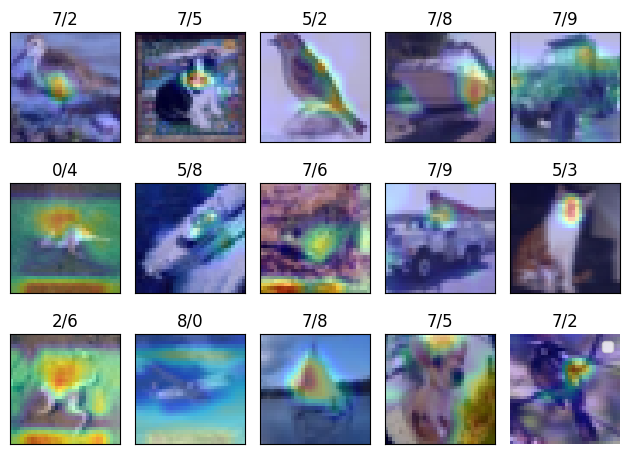

In [14]:
plot_grad_cam_images(model,trainer.incorrect_examples, trainer.incorrect_pred,  trainer.incorrect_labels)